In [1]:
print("strawberry")

strawberry


In [56]:
import torch
import numpy as np

# dataset
from twaidata.torchdatasets.in_ram_ds import MRISegmentation2DDataset, MRISegmentation3DDataset
from torch.utils.data import DataLoader, random_split, ConcatDataset

# model
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_deterministic import HyperMapp3r
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_DDU import HyperMapp3rDDU
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_SSN import HyperMapp3rSSN


# augmentation and pretrain processing
from trustworthai.utils.augmentation.standard_transforms import RandomFlip, GaussianBlur, GaussianNoise, \
                                                            RandomResizeCrop, RandomAffine, \
                                                            NormalizeImg, PairedCompose, LabelSelect, \
                                                            PairedCentreCrop, CropZDim
# loss function
from trustworthai.utils.losses_and_metrics.per_individual_losses import (
    dice_loss,
    log_cosh_dice_loss,
    TverskyLoss,
    FocalTverskyLoss,
    DiceLossMetric
)
from torch.nn import BCELoss, MSELoss, BCEWithLogitsLoss

# fitter
from trustworthai.utils.fitting_and_inference.fitters.basic_lightning_fitter import StandardLitModelWrapper
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
import pytorch_lightning as pl

# misc
import os
import torch
import matplotlib.pyplot as plt
import torch
from torchinfo import summary
import torch.distributions as td

### Set the seed

In [3]:
seed = 3407
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

### define datasets and dataloaders

In [4]:
is3D = False

In [5]:
#root_dir = "/disk/scratch/s2208943/ipdis/preprep/out_data/collated/"
root_dir = "/media/benp/NVMEspare/datasets/preprocessing_attempts/local_results/collated/"
wmh_dir = root_dir + "WMH_challenge_dataset/"
ed_dir = root_dir + "EdData/"

In [6]:
domains = [
            wmh_dir + d for d in ["Singapore", "Utrecht", "GE3T"]
          ]

# domains = [
#             wmh_dir + d for d in ["Singapore", "Utrecht", "GE3T"]
#           ] + [
#             ed_dir + d for d in ["domainA", "domainB", "domainC", "domainD"]
#           ]


# domains = [
#             ed_dir + d for d in ["domainA", "domainB", "domainC", "domainD"]
#           ]

In [7]:
# augmentation definintion
def get_transforms(is_3D):
    transforms = [
        LabelSelect(label_id=1),
        RandomFlip(p=0.5, orientation="horizontal"),
        # GaussianBlur(p=0.5, kernel_size=7, sigma=(.1, 1.5)),
        # GaussianNoise(p=0.2, mean=0, sigma=0.2),
        # RandomAffine(p=0.2, shear=(.1,3.)),
        # RandomAffine(p=0.2, degrees=5),
        #RandomResizeCrop(p=1., scale=(0.6, 1.), ratio=(3./4., 4./3.))
        RandomResizeCrop(p=1., scale=(0.3, 0.5), ratio=(3./4., 4./3.)) # ssn
    ]
    if not is_3D:
        transforms.append(lambda x, y: (x, y.squeeze().type(torch.long)))
        return PairedCompose(transforms)
    else:
        transforms.append(CropZDim(size=32, minimum=0, maximum=-1))
        transforms.append(lambda x, y: (x, y.squeeze().type(torch.long)))
        return PairedCompose(transforms)

In [8]:
# function to do train validate test split
test_proportion = 0.1
validation_proportion = 0.2

def train_val_test_split(dataset, val_prop, test_prop, seed):
    # I think the sklearn version might be prefereable for determinism and things
    # but that involves fiddling with the dataset implementation I think....
    size = len(dataset)
    test_size = int(test_prop*size) 
    val_size = int(val_prop*size)
    train_size = size - val_size - test_size
    train, val, test = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(seed))
    return train, val, test

In [9]:
# load datasets
# this step is quite slow, all the data is being loaded into memory
if is3D:
    datasets_domains = [MRISegmentation3DDataset(root_dir, domain, transforms=get_transforms(is_3D=True)) for domain in domains]
else:
    datasets_domains = [MRISegmentation2DDataset(root_dir, domain, transforms=get_transforms(is_3D=False)) for domain in domains]

# split into train, val test datasets
datasets = [train_val_test_split(dataset, validation_proportion, test_proportion, seed) for dataset in datasets_domains]

# concat the train val test datsets
train_dataset = ConcatDataset([ds[0] for ds in datasets])
val_dataset = ConcatDataset([ds[1] for ds in datasets])
test_dataset = ConcatDataset([ds[2] for ds in datasets])

In [10]:
len(train_dataset), len(val_dataset), len(test_dataset)

(2506, 716, 358)

In [188]:
# define dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size = 16, shuffle=False, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)

### setup model

In [12]:
in_channels = 3
out_channels = 1

if is3D:
    pass
else:
    # encoder_features=[16, 32, 64, 128, 256] # orig: [16, 32, 64, 128, 256]
    # decoder_features=encoder_features[::-1][1:]
    model = HyperMapp3r(dims=2,
                 in_channels=3,
                 out_channels=2,
                 encoder_features=[16, 32, 64, 128, 256],
                 decoder_features=[128, 64, 32, 16],
                 softmax=False,
                 up_res_blocks=False,
                 block_params={
                     "dropout_p":0.1,
                     "norm_type":"in", 
                     "dropout_both_layers":False,
                 }
                   )
    
    
    optimizer_params={"lr":2e-3}
    lr_scheduler_params={"step_size":20, "gamma":0.1}
    # optimizer_params={"lr":2e-3, "momentum":0.6}
    # optimizer = torch.optim.RMSprop
    # lr_scheduler_params={"milestones":[10,100,200], "gamma":0.5}
    # lr_scheduler_constructor = torch.optim.lr_scheduler.MultiStepLR


In [13]:
summary(model, (1, 3, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
HyperMapp3r                              --                        --
├─ModuleList: 1-1                        --                        --
├─ModuleList: 1-2                        --                        --
├─ModuleList: 1-3                        --                        --
├─ModuleList: 1-4                        --                        --
├─ModuleList: 1-5                        --                        --
├─ModuleList: 1-2                        --                        --
│    └─Conv2d: 2-1                       [1, 16, 64, 64]           448
├─ModuleList: 1-1                        --                        --
│    └─HM3Block: 2-2                     [1, 16, 64, 64]           --
│    │    └─InstanceNorm2d: 3-1          [1, 16, 64, 64]           --
│    │    └─LeakyReLU: 3-2               [1, 16, 64, 64]           --
│    │    └─Conv2d: 3-3                  [1, 16, 64, 64]           2,304
│    │    └

In [14]:
loss = dice_loss
#loss = torch.nn.CrossEntropyLoss(weight=torch.Tensor([0.968, 0.032]))
#loss = FocalLoss(gamma=1., reduction='mean', alpha=torch.Tensor([1-0.968, 1-0.032]))
#loss = log_cosh_dice_loss
#loss = TverskyLoss(beta=0.7)
#loss = FocalTverskyLoss(beta=0.7, gamma=0.8)

In [15]:
optimizer_params={"lr":2e-4, "momentum":0.6}
optimizer = torch.optim.RMSprop
lr_scheduler_params={"milestones":[100,200], "gamma":0.5}
lr_scheduler_constructor = torch.optim.lr_scheduler.MultiStepLR

In [16]:
model = StandardLitModelWrapper(model, loss, 
                                logging_metric=lambda : None,
                                optimizer_params=optimizer_params,
                                lr_scheduler_params=lr_scheduler_params,
                                is_uq_model=False,
                                optimizer_constructor=optimizer,
                                lr_scheduler_constructor=lr_scheduler_constructor
                               )

In [17]:
checkpoint_dir = "./lightning_logs"
strategy = None
# strategy = "deepspeed_stage_2"
# strategy = "dp"
#strategy = "deepspeed_stage_2_offload"

accelerator="gpu"
devices=1
max_epochs=500
precision = 32

checkpoint_callback = ModelCheckpoint(checkpoint_dir, save_top_k=2, monitor="val_loss")
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=500, verbose="False", mode="min", check_finite=True)
trainer = pl.Trainer(
    callbacks=[checkpoint_callback, early_stop_callback],
    accelerator=accelerator,
    devices=devices,
    max_epochs=max_epochs,
    strategy=strategy,
    precision=precision,
    default_root_dir=checkpoint_dir
)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### train

In [18]:
trainer.fit(model, train_dataloader, val_dataloader)

/home/benp/anaconda3/envs/ip/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /home/benp/Documents/Dissertation/Trustworthai-MRI-WMH/trustworthai/models/uq_models/initial_variants/lightning_logs exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params
--------------------------------------
0 | model | HyperMapp3r | 2.8 M 
--------------------------------------
2.8 M     Trainable params
0         Non-trainable params
2.8 M     Total params
11.098    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/benp/anaconda3/envs/ip/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batches (40) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 0.351


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.037 >= min_delta = 0.0. New best score: 0.314


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.298


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.292


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.273


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.260


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.237


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.226


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.224


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.215


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.210


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.208


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.202


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.202


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.191


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.191


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/benp/anaconda3/envs/ip/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:724: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [20]:
trainer.validate(model, val_dataloader)#, ckpt_path='best')

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.20355086028575897
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.20355086028575897}]

In [189]:
x1, y1 = next(iter(val_dataloader))

In [190]:
with torch.no_grad():
    model.eval()
    y_hat = model(x1.to(model.device))

In [191]:
torch.max(x1)

tensor(6.1821)

In [192]:
dice_loss(y_hat, y1)


tensor(0.1898)

In [193]:
TverskyLoss(beta=0.7)(y_hat, y1)

tensor(0.1835)

In [194]:
def actual_dice(y_hat, y_true):
    y_hat = torch.nn.functional.softmax(y_hat, dim=1).argmax(dim=1)
    # count how many times the ground truth and target have nothing in them
    s0 = y_hat.shape[0]
    y_hat = y_hat.view(s0, -1)
    y_true = y_true.view(s0, -1)
    # print(torch.sum(torch.sum(y_true, dim=1) == 0))
    # print(torch.sum(torch.sum(y_hat, dim=1) == 0))
    # print(torch.sum(torch.logical_and(torch.sum(y_hat, dim=1) == 0, torch.sum(y_true, dim=1) == 0)))
    ignores = torch.sum(torch.logical_and(torch.sum(y_hat, dim=1) == 0, torch.sum(y_true, dim=1) == 0))
    
    
    numerator = torch.sum(2 * y_true * y_hat, dim=1)
    # print(numerator)
    denominator = torch.sum(y_true + y_hat, dim=1)
    # print(denominator)
    
    return torch.sum((numerator)/ (denominator + 1e-8)) / (s0-ignores) # s0

In [195]:
def slice_dice(y_hat, y_true):
    # print(y_hat.shape)
    y_hat = torch.nn.functional.softmax(y_hat, dim=0).argmax(dim=0)
    
    if torch.sum(y_hat) == 0 and torch.sum(y_true) == 0:
        return "n/a"
    
    # print(y_hat.shape)
    # print(y_true.shape)
    
    numerator = torch.sum(2 * y_hat * y_true)
    denominator = torch.sum(y_hat + y_true)
    return numerator / (denominator + 1e-8)

In [196]:
def dice(y_pred, y_true):
    y_pred = torch.nn.functional.softmax(y_pred, dim=1).argmax(dim=1)
    denominator = torch.sum(y_pred) + torch.sum(y_true)
    numerator = 2. * torch.sum(torch.logical_and(y_pred, y_true))
    return numerator / denominator

In [197]:
dice(y_hat, y1)

tensor(0.7863)

In [198]:
actual_dice(y_hat, y1)

tensor(0.5428)

tensor(0.)


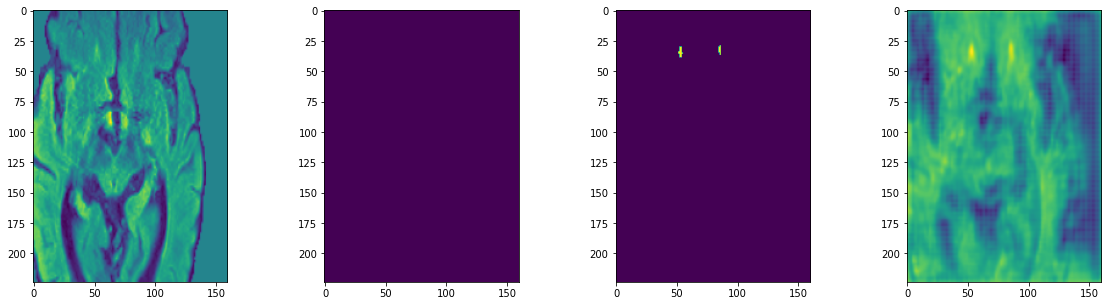

In [202]:
ind = 61
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.imshow(x1[ind][0,:,:])
plt.subplot(1,4,2)
plt.imshow(y1[ind])
plt.subplot(1,4,3)
plt.imshow(y_hat.softmax(dim=1).argmax(dim=1)[ind])
plt.subplot(1,4,4)
plt.imshow(y_hat[ind][1])
print(slice_dice(y_hat[ind], y1[ind]))
plt.show()

### Building the DDU uncertainty map

In [32]:
from tqdm import tqdm

In [33]:
# compute the mus
with torch.no_grad():
    classes = 2
    mus = torch.zeros(classes, classes)
    pi_s = torch.zeros(classes)
    num_voxels = 0
    for i, (x, y) in tqdm(enumerate(train_dataloader), total=len(train_dataloader), ncols=150, position=0, leave=True):
        y_hat = model(x)
        
        for c in range(classes):
            c_map = (y == c).expand(2, *y.shape).swapaxes(0,1) # make a shape of [n, c, dims...]
            y_hat_at_c = y_hat * c_map
            total = torch.sum(y_hat_at_c, dim=[0,2,3])
            elems = torch.sum(y==c)
            mus[c] +=  (1./(i+1.)) * (total/ elems - mus[c])  # average update rule for mu's
            pi_s[c] += elems
            num_voxels += elems
            
    pi_s /= num_voxels

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:21<00:00,  1.87it/s]


In [34]:
torch.sum(pi_s)

tensor(1.)

In [35]:
mus

tensor([[ 38.6896, -45.2371],
        [ -5.6257,   3.2501]])

In [36]:
# compute the mus
with torch.no_grad():
    mus2 = torch.zeros(classes, classes)
    pi_s = torch.zeros(classes)
    num_voxels = 0
    for i, (x, y) in tqdm(enumerate(train_dataloader), total=len(train_dataloader), ncols=150, position=0, leave=True):
        y_hat = model(x)

        for c in range(classes):
            voxels = y_hat.swapaxes(0,1).reshape(2, -1)
            # print(voxels.shape)
            locs = y.view(-1) == c
            # print(locs.shape)
            voxels = voxels[:,locs]
            mus2[c] += (1/(1.+i)) * (torch.sum(voxels, dim=1)/(voxels.shape[1]) - mus2[c])
            pi_s[c] += voxels.shape[1]
            num_voxels += locs.shape[0]
            
    pi_s /= num_voxels

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.91it/s]


In [37]:
mus2

tensor([[ 38.6832, -45.2296],
        [ -5.4601,   3.0313]])

In [ ]:
# compute the sigmas


In [158]:
# now literally compute it the naive way and check it is correct
classes = 2
with torch.no_grad():
    outs = {0:[], 1:[]}
    pis = torch.zeros(classes)
    num_voxels = 0
    for i, (x, y) in tqdm(enumerate(train_dataloader), total=len(train_dataloader), ncols=150, position=0, leave=True):
        y_hat = model(x)
        
        for c in range(classes):
            voxels = y_hat.swapaxes(0,1).reshape(2, -1)
            # print(voxels.shape)
            locs = y.view(-1) == c
            # print(locs.shape)
            voxels = voxels[:,locs]
            # print(voxels.shape)
            outs[c].append(voxels)
            pis[c] += voxels.shape[1]
            num_voxels += voxels.shape[1]
            

outs[0] = torch.cat(outs[0], dim=1)
outs[1] = torch.cat(outs[1], dim=1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:21<00:00,  1.87it/s]


In [159]:
mus3 = torch.zeros(classes, classes)
sigma  = torch.zeros(classes, classes, classes)
pis = pis / num_voxels
for c in range(classes):
    mus3[c] = torch.mean(outs[c], dim=1)
    sigma[c] = ((outs[c].T-mus3[c]).T @ (outs[c].T - mus3[c])) / (outs[c].shape[1] - 1)

In [160]:
mus3

tensor([[ 38.6575, -45.1987],
        [ -5.6215,   3.2222]])

In [161]:
sigma

tensor([[[ 472.8373, -550.8788],
         [-550.8788,  642.0833]],

        [[ 286.5698, -304.4380],
         [-304.4380,  324.5637]]])

In [162]:
pis, torch.sum(pis)

(tensor([0.9945, 0.0055]), tensor(1.0000))

In [375]:
normals = [td.MultivariateNormal(mus3[c], covariance_matrix=sigma[c]) for c in range(classes)]
def GMM_density(zs):
    # zs is of shape <some dims.., c> note c is the last dim
    # we then put c at the front for the conditoinal densities array
    conditional_densities = torch.zeros(classes, *zs.shape[:-1])
    for c in range(classes):
        conditional_densities[c] = normals[c].log_prob(zs) + pis[c]
    density = torch.sum(conditional_densities, dim=0)
    return density

def batch_GMM_density(y_hat):
    # y hat is of shape <n, c, dims...>
    y_hat = y_hat.permute(0, *list(range(2,len(y_hat.shape))), 1)
    print(y_hat.shape)
    return GMM_density(y_hat)

In [376]:
r = batch_GMM_density(y_hat)

torch.Size([64, 224, 160, 2])


In [377]:
with torch.no_grad():
    model.eval()
    y_hat = model(x1.to(model.device))

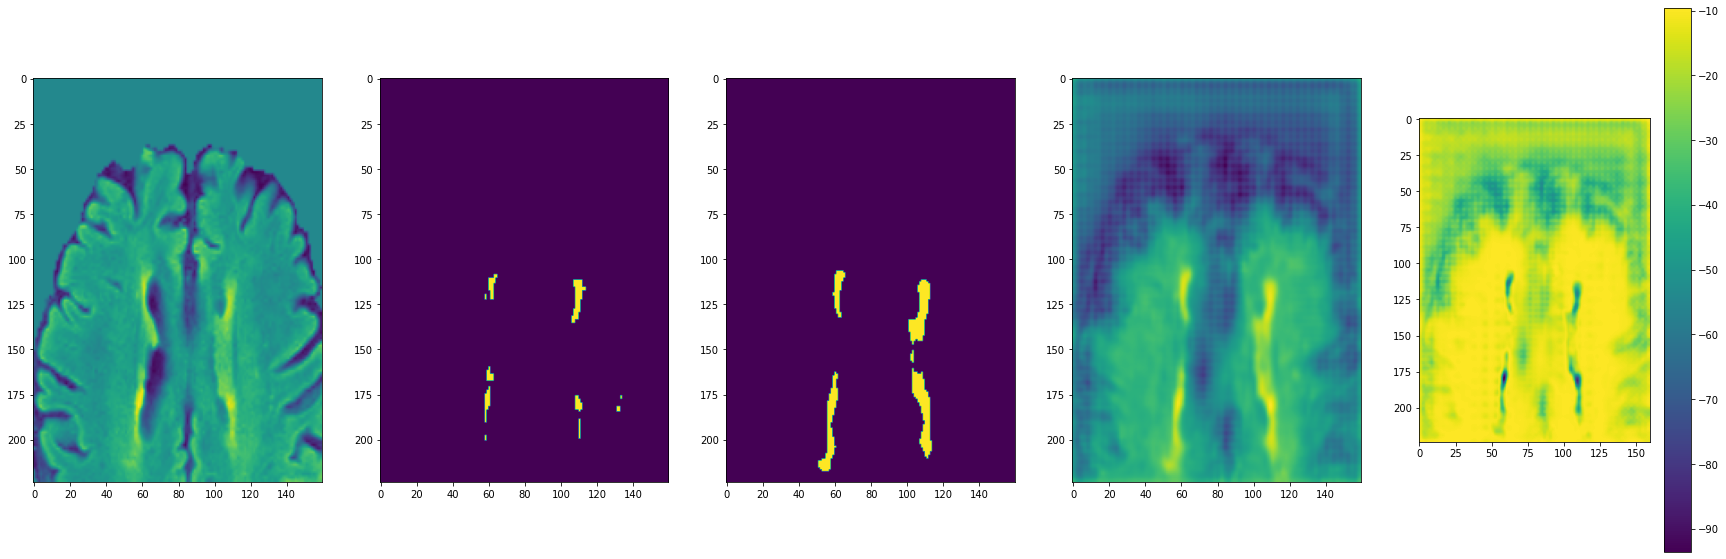

In [378]:
ind=16
plt.figure(figsize=(30,10))
plt.subplot(1,5,1)
plt.imshow(x1[ind][0])
plt.subplot(1,5,2)
plt.imshow(y1[ind])
plt.subplot(1,5,3)
plt.imshow(torch.nn.functional.softmax(y_hat, dim=1).argmax(dim=1)[ind])
plt.subplot(1,5,4)
plt.imshow(y_hat[ind][1])
plt.subplot(1,5,5)
plt.imshow(r[ind])
plt.colorbar()
plt.show()

In [225]:
torch.max(r)

tensor(0.0137)

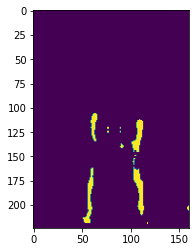

In [230]:
plt.imshow(r[ind]<0.00005)

### trying learning a density estimation directly

In [ ]:
def GMM_density_learnable(zs, gmm):
    # zs is of shape <some dims.., c> note c is the last dim
    # we then put c at the front for the conditoinal densities array
    conditional_densities = torch.zeros(classes, *zs.shape[:-1])
    for c in range(classes):
        conditional_densities[c] = gmm.normals[c].log_prob(zs) + pis[c]
    log_density = torch.sum(conditional_densities, dim=0)
    return log_density

def batch_GMM_density_learnable(y_hat):
    # y hat is of shape <n, c, dims...>
    y_hat = y_hat.permute(0, *list(range(2,len(y_hat.shape))), 1)
    print(y_hat.shape)
    return GMM_density(y_hat)

In [424]:
import torch.nn as nn
class GMM_model(nn.Module):
    def __init__(self, ):
        super().__init__()
        self.mu = nn.parameter.Parameter(torch.randn(classes, classes))
        self.cov_l = nn.parameter.Parameter(torch.randn(classes, int(0.5 * classes * (classes + 1))))
        
    def forward(self, x):
        with torch.no_grad():
            model.eval()
            device = model.device
            y_hat = model(x.to(device))
            y_hat = torch.nn.functional.softmax(y_hat, dim=1)
        mus = self.mu
        covls = [torch.zeros(classes, classes).to(device) for c in range(classes)]
        tril_indices = torch.tril_indices(row=classes,col=classes,offset=0).to(device)
        # print(tril_indices.device)
        # print(covls[0].device)
        # print(self.cov_l.device)
        # print(device)
        for c in range(classes):
            covls[c][tril_indices[0], tril_indices[1]] = self.cov_l[c]
        covs = [covls[c] @ covls[c].T for c in range(classes)]
        
        gmm_normals = [td.MultivariateNormal(mus[c], covs[c]) for c in range(classes)]
        
        return (y_hat, gmm_normals)
    
    def get_density(self, x):
        y_hat, gmm_normals = self(x)
        y_hat = y_hat.permute(0, *list(range(2,len(y_hat.shape))), 1)
        conditional_densities = torch.zeros(classes, *y_hat.shape[:-1])
        for c in range(classes):
            conditional_densities[c] = gmm_normals[c].log_prob(y_hat) + pis[c]
        log_density = torch.sum(conditional_densities, dim=0)
        
        return log_density
    
    def loss(self, gmm_out, target):
        y_hat, gmm_normals = gmm_out
        y_hat = y_hat.permute(0, *list(range(2,len(y_hat.shape))), 1).reshape(-1,2)
        y = target.view(-1)
        #print(y_hat.shape, y.shape)
        log_density_sum = torch.Tensor([0.])
        
        for c in range(classes):
            locs = y == c
            voxels_c = y_hat[locs,:]
            conditional_densities = gmm_normals[c].log_prob(voxels_c) + pis[c]
            log_density_sum += torch.sum(conditional_densities, dim=0)
        
        return -log_density_sum / y.shape[0]

In [498]:
class GMM_model_arbitrary(nn.Module):
    def __init__(self, ):
        super().__init__()
        self.dists = 10
        self.mu = nn.parameter.Parameter(torch.randn(self.dists, classes))
        self.cov_l = nn.parameter.Parameter(torch.randn(self.dists, int(0.5 * classes * (classes + 1))))
        self.dist_probs = nn.parameter.Parameter(torch.randn(self.dists))
        
    def forward(self, x):
        with torch.no_grad():
            model.eval()
            device = model.device
            y_hat = model(x.to(device))
            #y_hat = torch.nn.functional.softmax(y_hat, dim=1)
        mus = self.mu
        covls = [torch.zeros(classes, classes).to(device) for c in range(self.dists)]
        tril_indices = torch.tril_indices(row=classes,col=classes,offset=0).to(device)
        # print(tril_indices.device)
        # print(covls[0].device)
        # print(self.cov_l.device)
        # print(device)
        for c in range(self.dists):
            covls[c][tril_indices[0], tril_indices[1]] = self.cov_l[c]
        covs = [covls[c] @ covls[c].T for c in range(self.dists)]
        
        gmm_normals = [td.MultivariateNormal(mus[c], covs[c]) for c in range(self.dists)]
        
        dist_probs = torch.nn.functional.softmax(self.dist_probs, dim=0)
        
        return (y_hat, gmm_normals, dist_probs)
    
    def get_density(self, x):
        y_hat, gmm_normals, dist_probs = self(x)
        y_hat = y_hat.permute(0, *list(range(2,len(y_hat.shape))), 1)
        conditional_densities = torch.zeros(self.dists, *y_hat.shape[:-1])
        for c in range(self.dists):
            conditional_densities[c] = gmm_normals[c].log_prob(y_hat) + dist_probs[c]
        log_density = torch.sum(conditional_densities, dim=0)
        
        return log_density
    
    def loss(self, gmm_out, target):
        y_hat, gmm_normals, dist_probs = self(x)
        y_hat = y_hat.permute(0, *list(range(2,len(y_hat.shape))), 1)
        conditional_densities = torch.zeros(self.dists, *y_hat.shape[:-1])
        for c in range(self.dists):
            conditional_densities[c] = gmm_normals[c].log_prob(y_hat) + dist_probs[c]
        log_density = torch.sum(conditional_densities, dim=0)
        
        return -torch.mean(log_density)

In [499]:
#gmm = GMM_model()
gmm = GMM_model_arbitrary()

In [500]:
gmm_trainer = pl.Trainer(
    accelerator=model.device,
    devices=devices,
    max_epochs=max_epochs,
    strategy=strategy,
    precision=precision,
    default_root_dir=checkpoint_dir
)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [501]:
optimizer_params={"lr":2e-1, "momentum":0.6}
optimizer = torch.optim.RMSprop
lr_scheduler_params={"milestones":[100,200], "gamma":0.5}
lr_scheduler_constructor = torch.optim.lr_scheduler.MultiStepLR

In [502]:
gmm_model = StandardLitModelWrapper(gmm, gmm.loss, 
                                logging_metric=lambda : None,
                                optimizer_params=optimizer_params,
                                lr_scheduler_params=lr_scheduler_params,
                                is_uq_model=False,
                                optimizer_constructor=optimizer,
                                lr_scheduler_constructor=lr_scheduler_constructor
                               )

In [505]:
gmm_trainer.fit(gmm_model, train_dataloader)


  | Name  | Type                | Params
----------------------------------------------
0 | model | GMM_model_arbitrary | 60    
----------------------------------------------
60        Trainable params
0         Non-trainable params
60        Total params
0.000     Total estimated model params size (MB)


Training: 1it [00:00, ?it/s]

In [506]:
gmm.mu

Parameter containing:
tensor([[ 36.0373, -42.2108],
        [ 30.0676, -39.9653],
        [ 31.0827, -35.3792],
        [ 29.5377, -34.4423],
        [ 23.0227, -26.7248],
        [ 31.2039, -36.6626],
        [ 25.1580, -29.3639],
        [ 31.0527, -40.4885],
        [ 35.9659, -42.1350],
        [ 33.4622, -39.0825]], requires_grad=True)

In [511]:
device=model.device
covls = [torch.zeros(classes, classes).to(device) for c in range(gmm.dists)]
tril_indices = torch.tril_indices(row=classes,col=classes,offset=0).to(device)
# print(tril_indices.device)
# print(covls[0].device)
# print(self.cov_l.device)
# print(device)
for c in range(classes):
    covls[c][tril_indices[0], tril_indices[1]] = gmm.cov_l[c]
covs = [covls[c] @ covls[c].T for c in range(gmm.dists)]

In [512]:
covs

[tensor([[ 457.2046, -531.8091],
         [-531.8091,  630.9874]], grad_fn=<MmBackward0>),
 tensor([[ 314.6663, -436.4778],
         [-436.4778,  695.4589]], grad_fn=<MmBackward0>),
 tensor([[0., 0.],
         [0., 0.]]),
 tensor([[0., 0.],
         [0., 0.]]),
 tensor([[0., 0.],
         [0., 0.]]),
 tensor([[0., 0.],
         [0., 0.]]),
 tensor([[0., 0.],
         [0., 0.]]),
 tensor([[0., 0.],
         [0., 0.]]),
 tensor([[0., 0.],
         [0., 0.]]),
 tensor([[0., 0.],
         [0., 0.]])]

### todo, the above is broken as the rest of the covs seem to be zero, and I also think I should do exp, then times by pi, and then log again....

### I'm trying to learn multiple fnuctions instead of one per class

### I could try weighting the loss by the true class probabilities for the two classes now I am not learning one distribution per class now.

In [444]:
with torch.no_grad():
    p = gmm.get_density(x1)
    #p = gmm(x1)

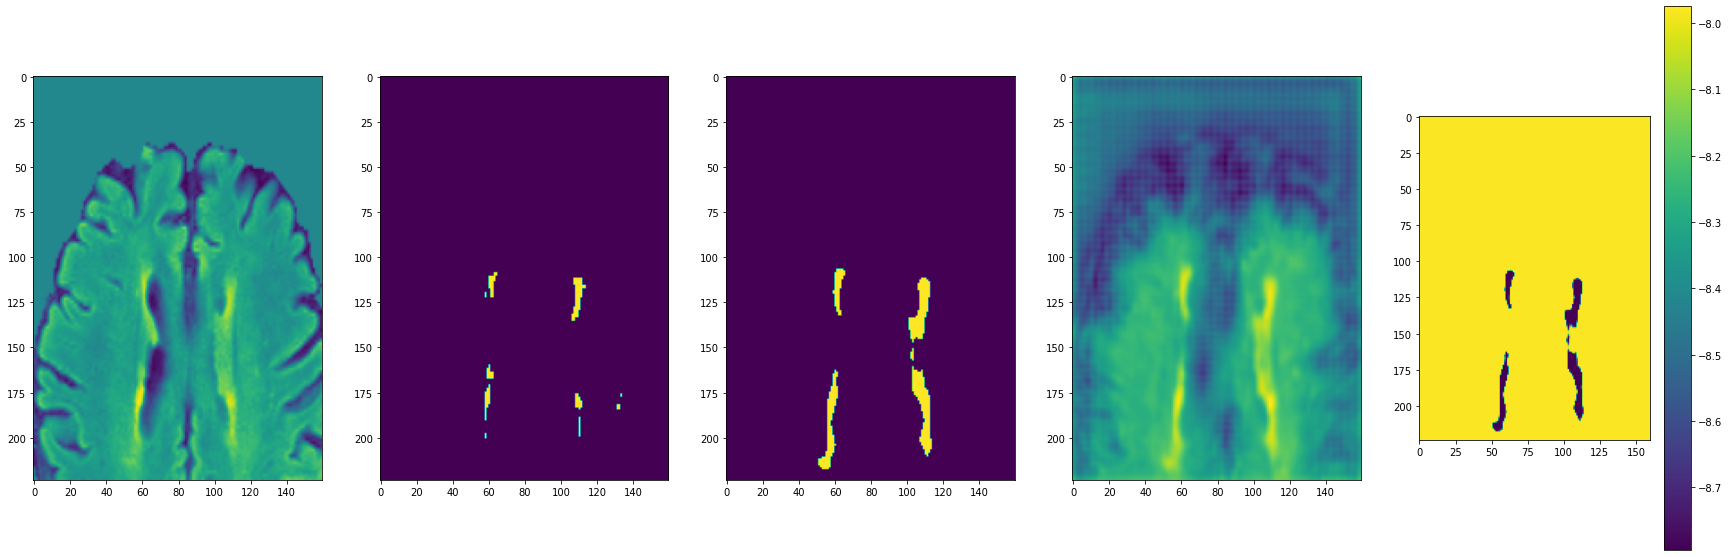

In [445]:
ind=16
plt.figure(figsize=(30,10))
plt.subplot(1,5,1)
plt.imshow(x1[ind][0])
plt.subplot(1,5,2)
plt.imshow(y1[ind])
plt.subplot(1,5,3)
plt.imshow(torch.nn.functional.softmax(y_hat, dim=1).argmax(dim=1)[ind])
plt.subplot(1,5,4)
plt.imshow(y_hat[ind][1])
plt.subplot(1,5,5)
plt.imshow(p[ind])
plt.colorbar()
plt.show()

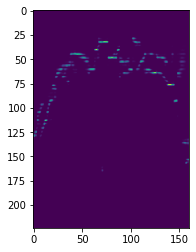

In [435]:
plt.imshow(torch.nn.functional.softmax(y_hat[16], dim=1)[0])

In [423]:
torch.nn.functional.softmax(y_hat, dim=1)[16][1]

tensor([[6.1515e-23, 4.3001e-25, 2.1012e-29,  ..., 3.5355e-30, 4.8825e-24,
         5.7378e-21],
        [5.8306e-25, 2.4615e-27, 4.3868e-32,  ..., 2.2918e-33, 1.6662e-26,
         4.4926e-23],
        [5.2381e-29, 8.0654e-32, 1.9121e-37,  ..., 9.6302e-40, 1.9404e-31,
         2.7543e-27],
        ...,
        [2.1529e-25, 6.1369e-29, 4.9869e-36,  ..., 2.7714e-29, 1.7014e-22,
         4.2155e-19],
        [1.6607e-20, 1.9595e-23, 2.7281e-29,  ..., 5.8809e-24, 2.5164e-18,
         1.6460e-15],
        [4.6126e-18, 1.1073e-20, 6.3806e-26,  ..., 2.7091e-21, 3.0603e-16,
         1.0286e-13]])

### Looking at the 3D dice

In [65]:
# load datasets
# this step is quite slow, all the data is being loaded into memory
# BIG NOTE
# during evaluating the modle, we set is_3d false here to avoid doing the z cropping (which can cause nans)
# and instead we run the whole brain scan through and it gives us a good prediction over all. Nice.
datasets_domains_3d = [MRISegmentation3DDataset(root_dir, domain, transforms=get_transforms(is_3D=False)) for domain in domains]


# split into train, val test datasets
datasets_3d = [train_val_test_split(dataset, validation_proportion, test_proportion, seed) for dataset in datasets_domains_3d]

# concat the train val test datsets
train_dataset_3d = ConcatDataset([ds[0] for ds in datasets_3d])
val_dataset_3d = ConcatDataset([ds[1] for ds in datasets_3d])
test_dataset_3d = ConcatDataset([ds[2] for ds in datasets_3d])

In [66]:
len(train_dataset_3d), len(val_dataset_3d), len(test_dataset_3d)

(42, 12, 6)

In [67]:
values = []
with torch.no_grad():
    model.eval()
    for i, (scan, label) in enumerate(train_dataset_3d):
        flipped = scan.permute(1,0,2,3)
        model.eval()
        pred = model(flipped).cpu()
        score = dice(pred, label)
        if not torch.isnan(score):
            values.append(score)
        print(i, score)
mean = torch.mean(torch.Tensor(values))
print("----\nmean: ", mean)

0 tensor(0.8528)
1 tensor(0.6430)
2 tensor(0.8549)
3 tensor(0.8199)
4 tensor(0.8247)
5 tensor(0.8497)
6 tensor(0.8536)
7 tensor(0.7967)
8 tensor(0.8647)
9 tensor(0.8440)
10 tensor(0.8636)
11 tensor(0.6490)
12 tensor(0.8447)
13 tensor(0.5881)
14 tensor(0.7848)
15 tensor(0.5129)
16 tensor(0.5148)
17 tensor(0.8600)
18 tensor(0.4029)
19 tensor(0.7848)
20 tensor(0.6895)
21 tensor(0.8580)
22 tensor(0.8022)
23 tensor(0.4417)
24 tensor(0.8724)
25 tensor(0.5105)
26 tensor(0.8670)
27 tensor(0.5702)
28 tensor(0.6307)
29 tensor(0.7462)
30 tensor(0.5924)
31 tensor(0.6640)
32 tensor(0.7275)
33 tensor(0.6062)
34 tensor(0.6768)
35 tensor(0.6813)
36 tensor(0.7767)
37 tensor(0.7394)
38 tensor(0.7874)
39 tensor(0.8292)
40 tensor(0.7221)
41 tensor(0.8305)
----
mean:  tensor(0.7293)


In [68]:
### how many slices in dataset are empty

In [140]:
count = 0
for x, y, in train_dataset:
    if torch.sum(x[1]) == 0:
        count += 1

In [141]:
count

566

In [142]:
len(train_dataset)

2506

In [26]:
x1, y1 = next(iter(train_dataloader))

In [27]:
with torch.no_grad():
    for x, y in train_dataloader:
        model.train()
        result = model(x)

KeyboardInterrupt: 

In [29]:
loss(result, y1.cuda())

tensor(26425.8262, device='cuda:0')

In [30]:
x1.shape

torch.Size([64, 3, 224, 160])